### Importation des bibliothèques

In [1]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
from matplotlib import pyplot as plt

### Chargement des photos

In [2]:
data_with=[]
label_with=[]
data_without=[]
label_without=[]
Path_with ='./Mask_Data/with_mask/'
Path_without ='./Mask_Data/without_mask/'
l=int(-1)
for i in os.listdir(Path_with) :
    l=l+1
    image = cv2.imread(Path_with+i)
    b, g, r = cv2.split(image)
    image = cv2.merge([r, g, b])
    image=cv2.resize(image, (224,224))
    data_with.append(image)
    label_with.append([0,1])
print('#############################')
l=-1
for i in os.listdir(Path_without) :
    l=l+1
    image = cv2.imread(Path_without+i)
    b, g, r = cv2.split(image)
    image = cv2.merge([r, g, b])
    image=cv2.resize(image, (224,224))
    data_without.append(image)
    label_without.append([1,0])
print('#########################')

print('#############################')

#############################
#########################
#############################


In [3]:
print('Nombre de photos avec masque :', len(data_with))
print('Nombre de photos sans masque :', len(data_without))
print('###############################')
print(' Nombre de label avec masque :',len(label_with))
print(' Nombre de label sans masque :',len(label_without))

Nombre de photos avec masque : 755
Nombre de photos sans masque : 753
###############################
 Nombre de label avec masque : 755
 Nombre de label sans masque : 753


In [4]:
datas_image= np.concatenate([data_with[0:753],data_without])
datas_label=np.concatenate([label_with[0:753],label_without])

### Division du jeu de donnée : entraînement, validation et test

In [5]:
from sklearn.model_selection import train_test_split
x_train_int, x_test, y_train_int, y_test = train_test_split(datas_image , datas_label,test_size =0.2, random_state = 0)
x_train, x_val, y_train, y_val = train_test_split(x_train_int, y_train_int,test_size =0.2, random_state = 0)


In [6]:
print(x_train.shape)
print(x_val.shape)

(963, 224, 224, 3)
(241, 224, 224, 3)


### Affichage des premières images et leurs labels

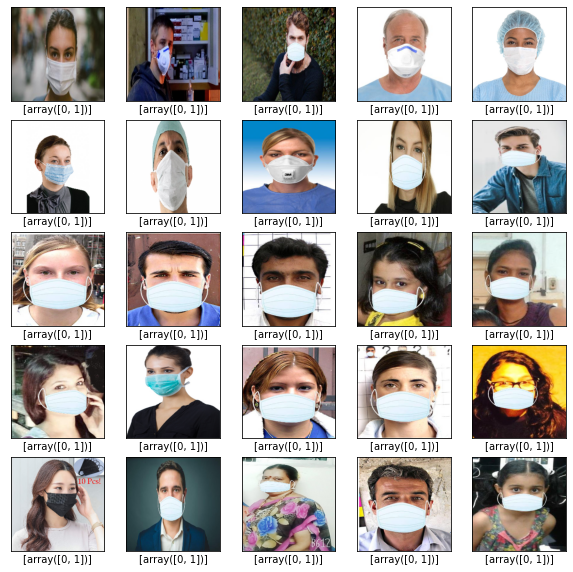

In [7]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(datas_image[i])
    plt.xlabel([datas_label[i]])
plt.show()

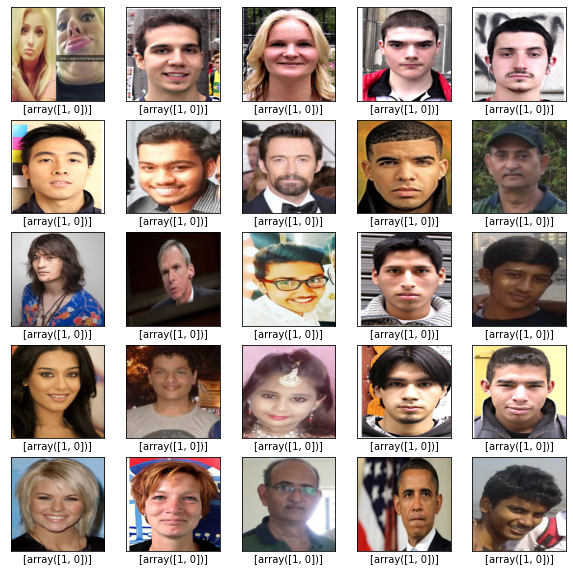

In [8]:

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(datas_image[i+800])
    plt.xlabel([datas_label[i+800]])
plt.show()

### Augmentation de données

In [9]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(x_train)

### Modèle VGG16

In [10]:

from keras.applications.vgg16 import VGG16
model = VGG16()
print(model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Blocage des premières couches et suppression des dernières

In [11]:
import keras
from keras import backend as K

# Modèle VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
# Freezer les couches du VGG16
for layer in base_model.layers:
    layer.trainable = False


### Ajout des couches inter-connectées

In [12]:
# Ajout des nouvelles couches
model = Sequential()
model.add(base_model) # Ajout du modèle VGG16
model.add(Flatten()) 
# print(model.summary())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

model.compile(optimizer='adam', loss=keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 4096)              16781312  
                                                                 
 dense_2 (Dense)             (None, 2)                 8194      
                                                                 
Total params: 134,268,738
Trainable params: 119,554,050
Non-trainable params: 14,714,688
_________________________________________________________________
None


### Création d'un fichier de sauvegarde du meilleur modèle

In [13]:
checkpoint_filepath = './Mask.h5'
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

### Entraînement du modèle (!)

In [14]:
history=model.fit(datagen.flow(x_train, y_train, batch_size = 32), epochs=10, validation_data=(x_val,y_val), callbacks=[checkpoint])

Epoch 1/10


C:\Users\Franky TANGUY\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


31/31 [==============================] - 376s 12s/step - loss: 7.2214 - accuracy: 0.8442 - val_loss: 2.2108 - val_accuracy: 0.9793
Epoch 2/10
31/31 [==============================] - 430s 14s/step - loss: 0.0693 - accuracy: 0.9792 - val_loss: 4.3509 - val_accuracy: 0.9668
Epoch 3/10
31/31 [==============================] - 382s 12s/step - loss: 0.0703 - accuracy: 0.9782 - val_loss: 3.2739 - val_accuracy: 0.9710
Epoch 4/10
31/31 [==============================] - 338s 11s/step - loss: 0.0505 - accuracy: 0.9813 - val_loss: 0.8485 - val_accuracy: 0.9876
Epoch 5/10
31/31 [==============================] - 397s 13s/step - loss: 0.0931 - accuracy: 0.9740 - val_loss: 1.8202 - val_accuracy: 0.9834
Epoch 6/10
31/31 [==============================] - 388s 13s/step - loss: 0.0155 - accuracy: 0.9927 - val_loss: 3.8602 - val_accuracy: 0.9834
Epoch 7/10
31/31 [==============================] - 384s 12s/step - loss: 0.0801 - accuracy: 0.9772 - val_loss: 3.2337 - val_accuracy: 0.9793
Epoch 8/10
31/31 

### Affichage de la précision du modèle pendant l'apprentissage

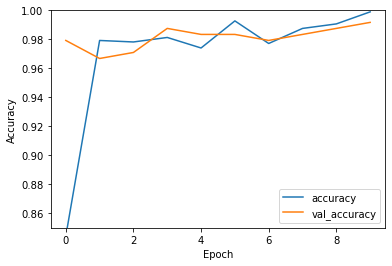

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.85, 1])
plt.legend(loc='lower right')

### Chargement du meilleur modèle

In [16]:
model = keras.models.load_model('./Mask.h5')

### Prédiction et évaluation du modèle (matrice de corrélation)

[[140   3]
 [  0 159]]


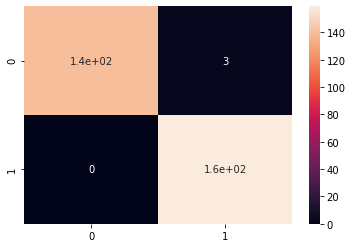

In [17]:
import seaborn as sns
y_pred = model.predict(x_test)
y_pred = np.array(y_pred)
y_pred = y_pred.argmax(axis = 1)
y_pred.shape
y_true = np.argmax(y_test, axis=1)
y_true.shape
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true,y_pred)
print(cm)
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True)

### Application à une image

0


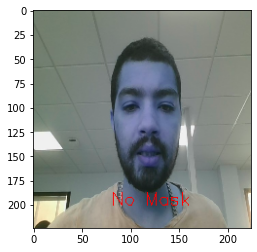

In [18]:
image_a_tester=cv2.imread('./img_test/1.jpg')
b, g, r = cv2.split(image_a_tester)
image_test_a_tester = cv2.merge([r, g, b])
image_a_tester=cv2.resize(image_a_tester, (224,224))

image_test= np.expand_dims(image_a_tester,axis=0)
image_test.shape
predictions = model.predict(image_test)
label_predit=np.argmax(predictions)
print(label_predit)
if label_predit==0 :
    message = "No Mask"
else :
    message = "Mask"
cv2.putText(image_a_tester, message, (80, 200), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0))
plt.imshow(image_a_tester)

### Application en temps réel

In [21]:
cap = cv2.VideoCapture(0)
while True:
    # Reading the frame from the camera
    _,frame = cap.read()
    #Flipping the frame to see same side of yours
    frame = cv2.flip(frame, 1)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    image_test=cv2.resize(frame, (224,224))

    image_test= np.expand_dims(image_test,axis=0)
    image_test.shape
    predictions = model.predict(image_test)
    label_predit=np.argmax(predictions)
    if label_predit==0 :
        message = "No Mask"
        cv2.putText(frame, message, (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255))
    else :
        message = "Masque"
        cv2.putText(frame, message, (40, 100), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0))
    cv2.imshow("Mask Detector", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
# Release the camera and all resources
cap.release()
cv2.destroyAllWindows()